<h2> Importing Libraries </h5>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from keras.losses import BinaryCrossentropy
from keras.metrics import Accuracy, Precision
from keras.optimizers.legacy import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
import glob
import random
from PIL import Image

/Users/devasheeshchopra/Desktop/MalariaDiagnosisProject/MalariaDiagnosis/MalariaDiagnosisEnv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [65]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

<h2> Explorartory Data Analysis </h2>

In [20]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/Users/devasheeshchopra/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in t

In [5]:
dataset_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})

In [7]:
dataset_info.description

'The Malaria dataset contains a total of 27,558 cell images with equal instances\nof parasitized and uninfected cells from the thin blood smear slide images of\nsegmented cells.'

In [16]:
print(f"Class 0: {dataset_info.features['label'].int2str(0)}")
print(f"Class 1: {dataset_info.features['label'].int2str(1)}")

Class 0: parasitized
Class 1: uninfected


<h2> Data Preprocessing </h2>

In [21]:
# Function to split dataset into train, test and validation sets

def split(dataset, train_ratio, val_ratio, test_ratio):
    dataset_size = len(dataset)
    
    train_set = dataset.take(int(train_ratio*dataset_size))
    val_test_set = dataset.skip(int(train_ratio*dataset_size))
    val_set = val_test_set.take(int(val_ratio*dataset_size))
    test_set = val_test_set.skip(int(val_ratio*dataset_size))
    
    return train_set, val_set, test_set

In [44]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
train_set, val_set, test_set = split(dataset=dataset[0], train_ratio=train_ratio, val_ratio=val_ratio, test_ratio=test_ratio)

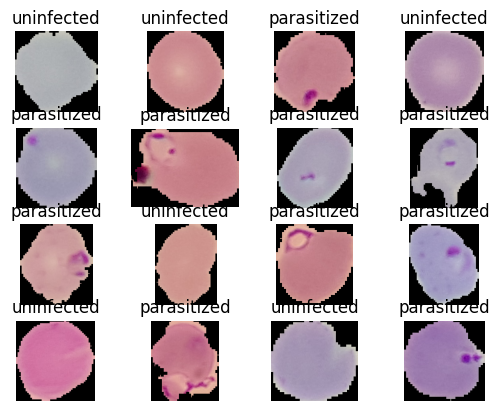

In [11]:
for i, (image, label) in enumerate(train_set.take(16)):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

<h4> Standardisation </h4>

In [45]:
# Function to standardise data
image_size = 224
def resize_rescale(image, label):
    return tf.image.resize(image, (image_size, image_size))/255.0, label

In [46]:
train_set = train_set.map(resize_rescale)
val_set = val_set.map(resize_rescale)
test_set = test_set.map(resize_rescale)

In [47]:
train_set = train_set.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_set = val_set.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
test_set = test_set.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

<h4> Augmentation </h4>

In [8]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image=image)
    
    return image, label

augmented_train_set = train_set.map(augment_image)

<h2> Model Training </h2>

In [61]:
# Model Architecture

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [62]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 64)      256       
 chNormalization)                                                
                                                      

In [8]:
checkpoint_callback = ModelCheckpoint(filepath='model_checkpoint2.h5', save_best_only=True)
early_stopping_callback = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')

In [69]:
model.compile(optimizer=Adam(0.001), loss=BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
history = model.fit(
    augmented_train_set, 
    epochs=30, 
    validation_data=val_set, 
    verbose=True, 
    callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/30
689/689 [==============================] - ETA: 0s - loss: 0.1707 - accuracy: 0.9444

/Users/devasheeshchopra/Desktop/MalariaDiagnosisProject/MalariaDiagnosis/MalariaDiagnosisEnv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


689/689 [==============================] - 68s 98ms/step - loss: 0.1707 - accuracy: 0.9444 - val_loss: 0.1554 - val_accuracy: 0.9557
Epoch 2/30
689/689 [==============================] - 67s 97ms/step - loss: 0.1617 - accuracy: 0.9469 - val_loss: 0.1865 - val_accuracy: 0.9387
Epoch 3/30
689/689 [==============================] - 67s 98ms/step - loss: 0.1612 - accuracy: 0.9483 - val_loss: 0.1735 - val_accuracy: 0.9474
Epoch 4/30
689/689 [==============================] - 67s 98ms/step - loss: 0.1570 - accuracy: 0.9495 - val_loss: 0.1523 - val_accuracy: 0.9568
Epoch 5/30
689/689 [==============================] - 68s 98ms/step - loss: 0.1610 - accuracy: 0.9464 - val_loss: 0.2021 - val_accuracy: 0.9347
Epoch 6/30
689/689 [==============================] - 67s 98ms/step - loss: 0.1552 - accuracy: 0.9482 - val_loss: 0.2843 - val_accuracy: 0.8915
Epoch 7/30
689/689 [==============================] - 67s 97ms/step - loss: 0.1485 - accuracy: 0.9509 - val_loss: 0.1740 - val_accuracy: 0.9543
Epo

<h4> Plotting Results </h4>

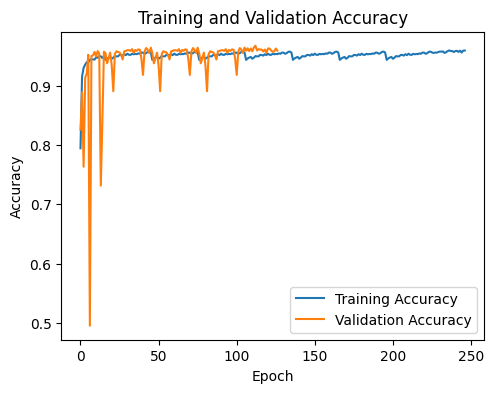

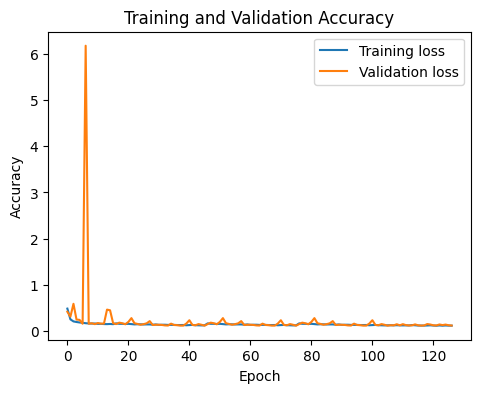

In [ ]:
# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()



<h4> Accuracy, Precision and Loss </h4>

In [9]:
model = load_model('test9576.h5')

In [10]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(from_logits=True),
              metrics=['accuracy', tf.keras.metrics.Precision()])

In [15]:
train_loss, train_accuracy,train_precision = model.evaluate(train_set)
print(f'Train Accuracy: {train_accuracy*100:.2f}%')
print(f'Train Precision: {train_precision*100:.2f}%')
print(f'Train Loss: {train_loss:.4f}')

689/689 [==============================] - 17s 24ms/step - loss: 0.1200 - accuracy: 0.9624 - precision: 0.9536
Train Accuracy: 96.24%
Train Precision: 95.36%
Train Loss: 0.1200


In [16]:
val_loss, val_accuracy, val_precision = model.evaluate(val_set)
print(f'Validation Accuracy: {val_accuracy*100:.2f}%')
print(f'Validation Precision: {val_precision*100:.2f}%')
print(f'Validation Loss: {val_loss:.4f}')

87/87 [==============================] - 3s 24ms/step - loss: 0.1211 - accuracy: 0.9652 - precision: 0.9564
Validation Accuracy: 96.52%
Validation Precision: 95.64%
Validation Loss: 0.1211


In [17]:
test_loss, test_accuracy, test_precision = model.evaluate(test_set)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')
print(f'Test Precision: {test_precision*100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

87/87 [==============================] - 3s 24ms/step - loss: 0.1348 - accuracy: 0.9576 - precision: 0.9575
Test Accuracy: 95.76%
Test Precision: 95.75%
Test Loss: 0.1348


<h2> Making Predictions </h2>

In [ ]:
model = load_model('App/test9576.h5')

2023-11-27 22:33:22.678816: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-27 22:33:22.678842: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-27 22:33:22.678847: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-27 22:33:22.678930: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-27 22:33:22.678980: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
parasitized_folder = 'App/CellImages/Parasitized'
uninfected_folder = 'App/CellImages/Uninfected'

In [ ]:
parasitized_images = glob.glob(f"{parasitized_folder}/*.png")
uninfected_images = glob.glob(f"{uninfected_folder}/*.png")
image_files = parasitized_images + uninfected_images

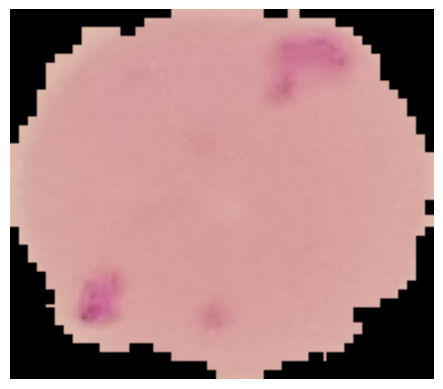

1/1 [==============================] - 0s 20ms/step
Expected: Parasitized
Prediction: Parasitized
Certainity: 99.6752%


In [ ]:
random_image_path = random.choice(image_files)

random_image = Image.open(random_image_path)
plt.imshow(random_image)
plt.axis('off')
plt.show()

expected_class = "Parasitized" if random_image_path in parasitized_images else "Uninfected"

img_array = np.array(random_image.resize((224, 224)))
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)

result = "Parasitized" if prediction[0][0] < 0.5 else "Uninfected"

print(f"Expected: {expected_class}")
print(f"Prediction: {result}")
print(f"Certainity: {((100 - (prediction[0][0]) * 100)) if prediction[0][0] < 0.5 else prediction[0][0]*100:.4f}%")